In [1]:
import os
import gpxpy

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

In [2]:
def read_gpx_to_df(file_path):
    with open(file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        data = []
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    hr = next((ext.text for ext in point.extensions if ext.tag.endswith('hr')), None)
                    data.append({
                        'time': point.time,
                        'hr': float(hr) if hr else None,
                        'filename': os.path.basename(file_path),
                    })
            
        gpx_df = pd.DataFrame(data)
        
        gpx_df['time'] = pd.to_datetime(gpx_df['time']).dt.floor('s')
        gpx_df['time'] = gpx_df['time'].dt.tz_localize(None)

        # Limit to the first hour only for clarity
        gpx_df = gpx_df[gpx_df['time'] < gpx_df['time'].iloc[0] + pd.Timedelta(hours=1)]

        gpx_df = gpx_df.set_index('time')
        gpx_df = gpx_df.resample('min').apply(
            lambda group: group.iloc[0] if group.name == 'filename' else group.mean()
        )
        gpx_df = gpx_df.reset_index()
        
        start_time = gpx_df['time'].min()
        gpx_df['seconds_since_start'] = (gpx_df['time'] - start_time).dt.total_seconds().astype(int)

        gpx_df['timestamp'] = pd.to_timedelta(gpx_df['seconds_since_start'], unit='s').apply(lambda x: '{:02}:{:02}:{:02}'.format(int(x.total_seconds() // 3600), int((x.total_seconds() % 3600) // 60), int(x.total_seconds() % 60)))
        gpx_df['timestamp'] = pd.to_datetime(gpx_df['timestamp'], format='%H:%M:%S').dt.time

        gpx_df = gpx_df.drop(['time', 'seconds_since_start'], axis=1)
        return gpx_df

with_files = [os.path.join('../data/with', f) for f in os.listdir('../data/with') if f.endswith('.gpx')]
without_files = [os.path.join('../data/without', f) for f in os.listdir('../data/without') if f.endswith('.gpx')]

dfs_with = [read_gpx_to_df(f) for f in with_files]
dfs_without = [read_gpx_to_df(f) for f in without_files]

df_with = pd.concat(dfs_with, ignore_index=True)
df_without = pd.concat(dfs_without, ignore_index=True)

df_with['category'] = 'with-h10'
df_without['category'] = 'without-h10'

df = pd.concat([df_with, df_without], ignore_index=True)
df.head()

,hr,filename,timestamp,category
0,124.162162,Evgeny_Arbatov_2024-12-07_06-33-22.gpx,00:00:00,with-h10
1,127.516667,Evgeny_Arbatov_2024-12-07_06-33-22.gpx,00:01:00,with-h10
2,126.016667,Evgeny_Arbatov_2024-12-07_06-33-22.gpx,00:02:00,with-h10
3,125.100000,Evgeny_Arbatov_2024-12-07_06-33-22.gpx,00:03:00,with-h10
4,124.033333,Evgeny_Arbatov_2024-12-07_06-33-22.gpx,00:04:00,with-h10


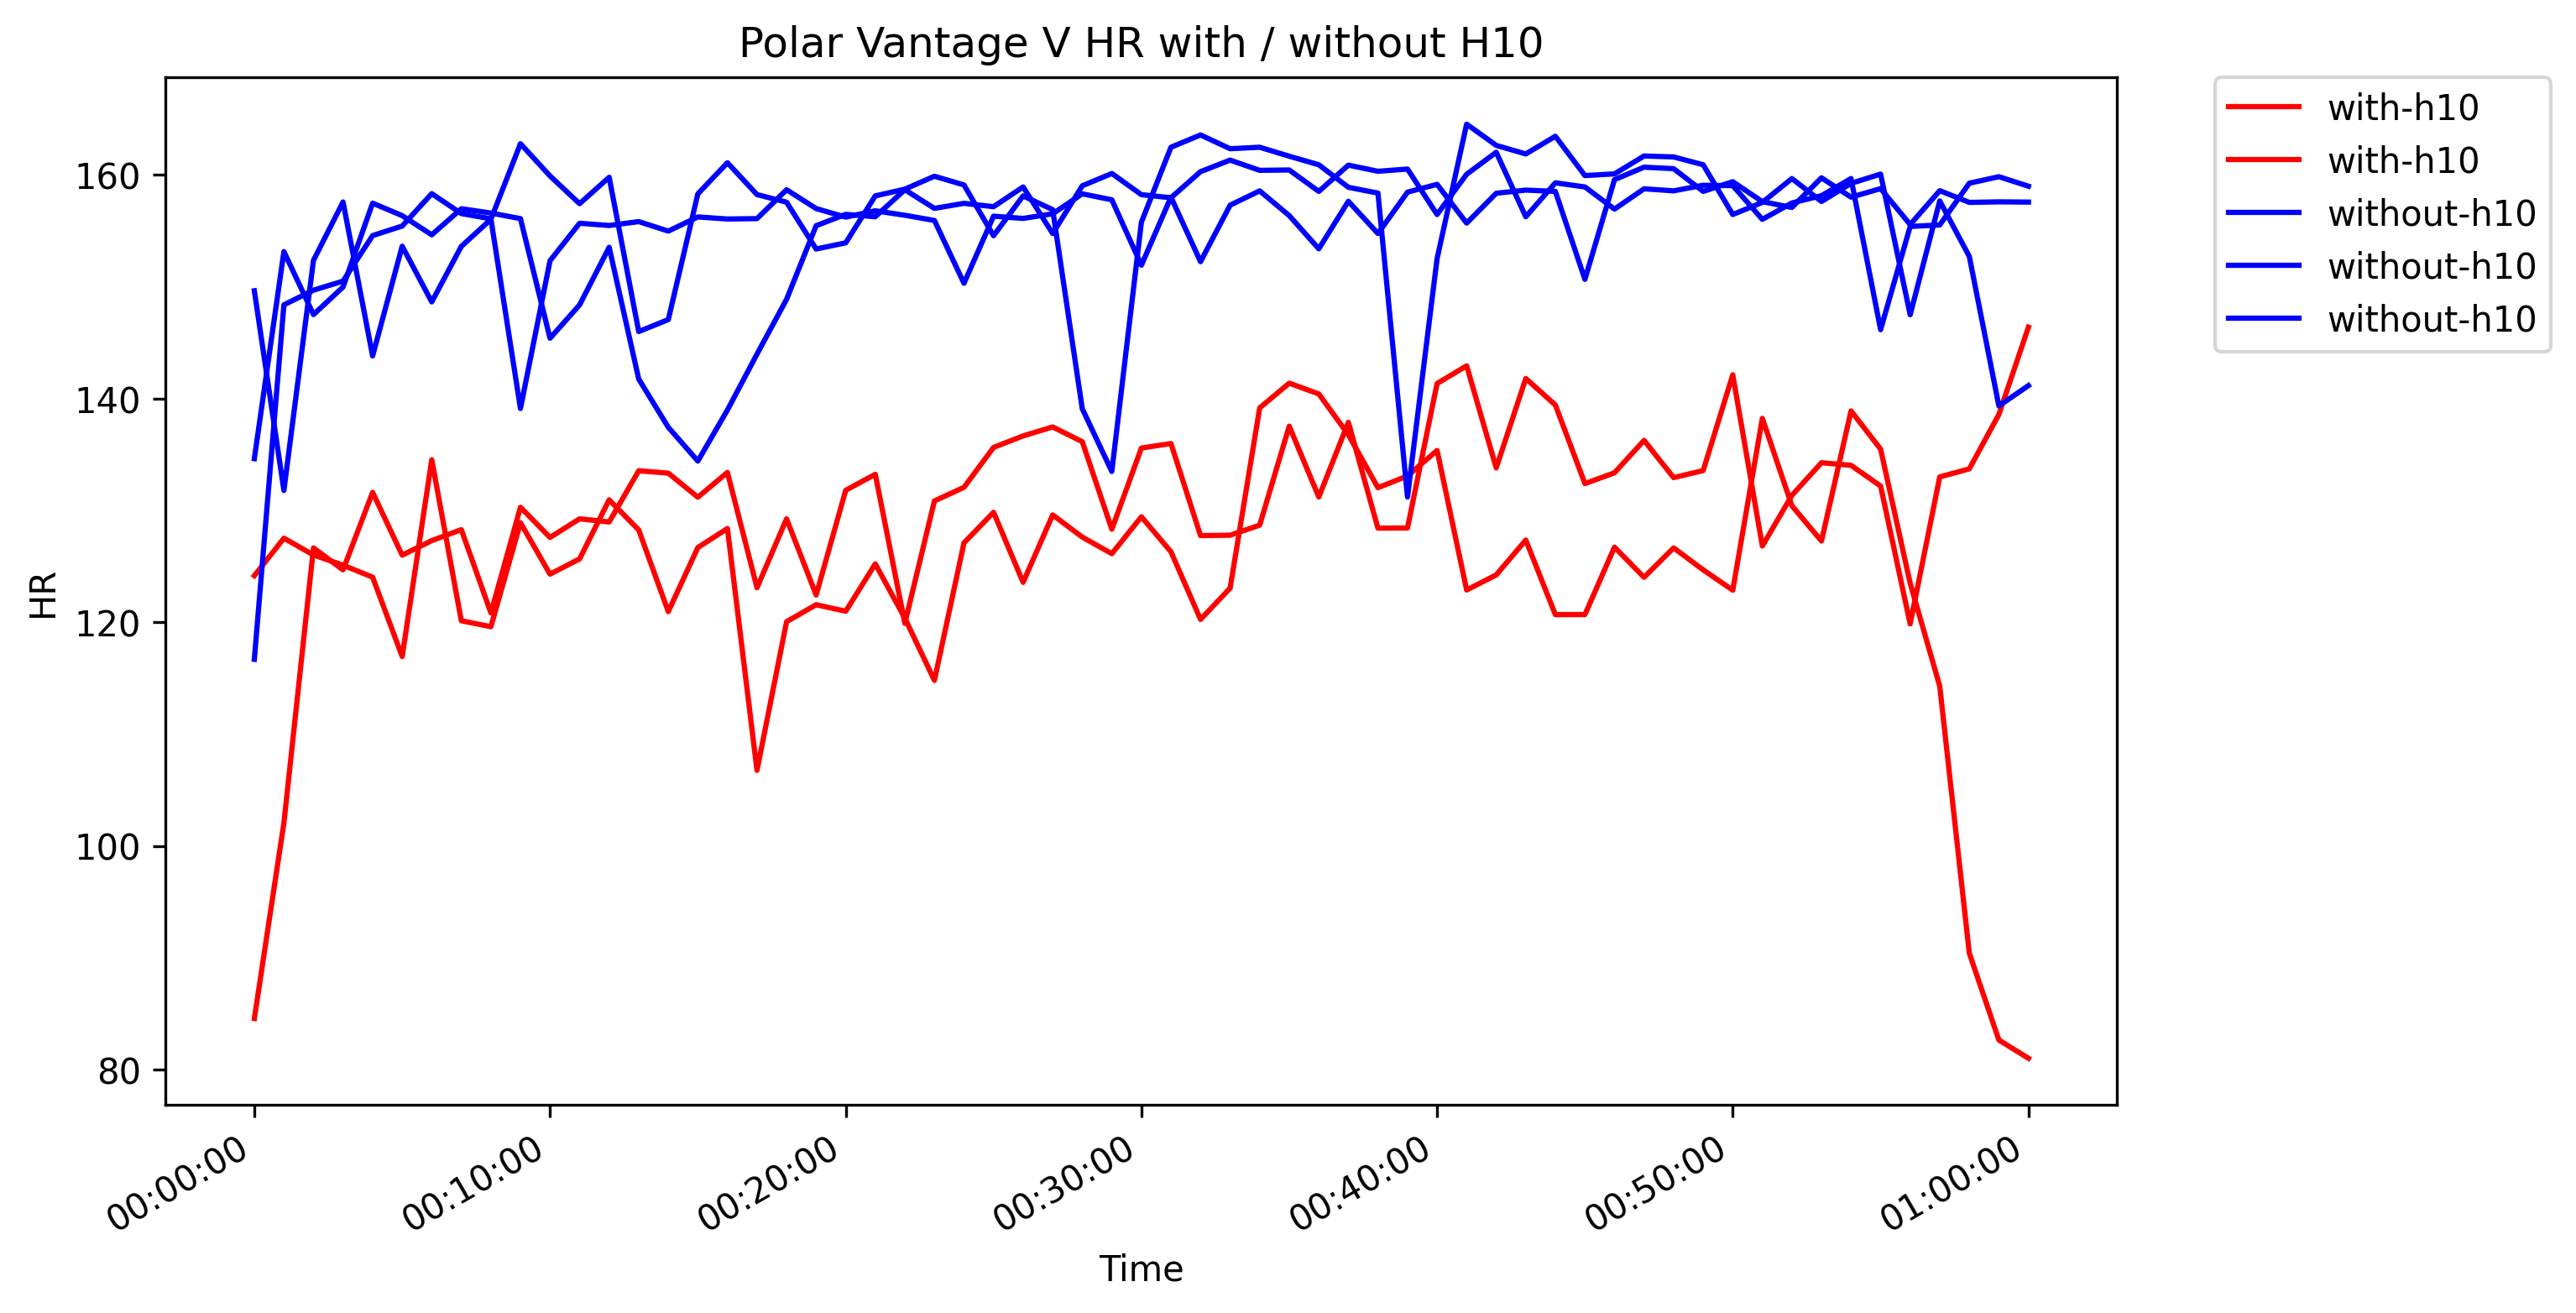

In [3]:
plt.figure(figsize=(10, 6), dpi=300)

plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

for (category, filename), group in df.groupby(['category', 'filename']):
    color = 'red' if category == 'with-h10' else 'blue'    
    group['timestamp'] = group['timestamp'].apply(lambda t: dt.datetime.combine(dt.date.today(), t))
    plt.plot(group['timestamp'], group['hr'], label=f'{category}', color=color)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.xlabel('Time')
plt.ylabel('HR')
plt.title('Polar Vantage V HR with / without H10')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

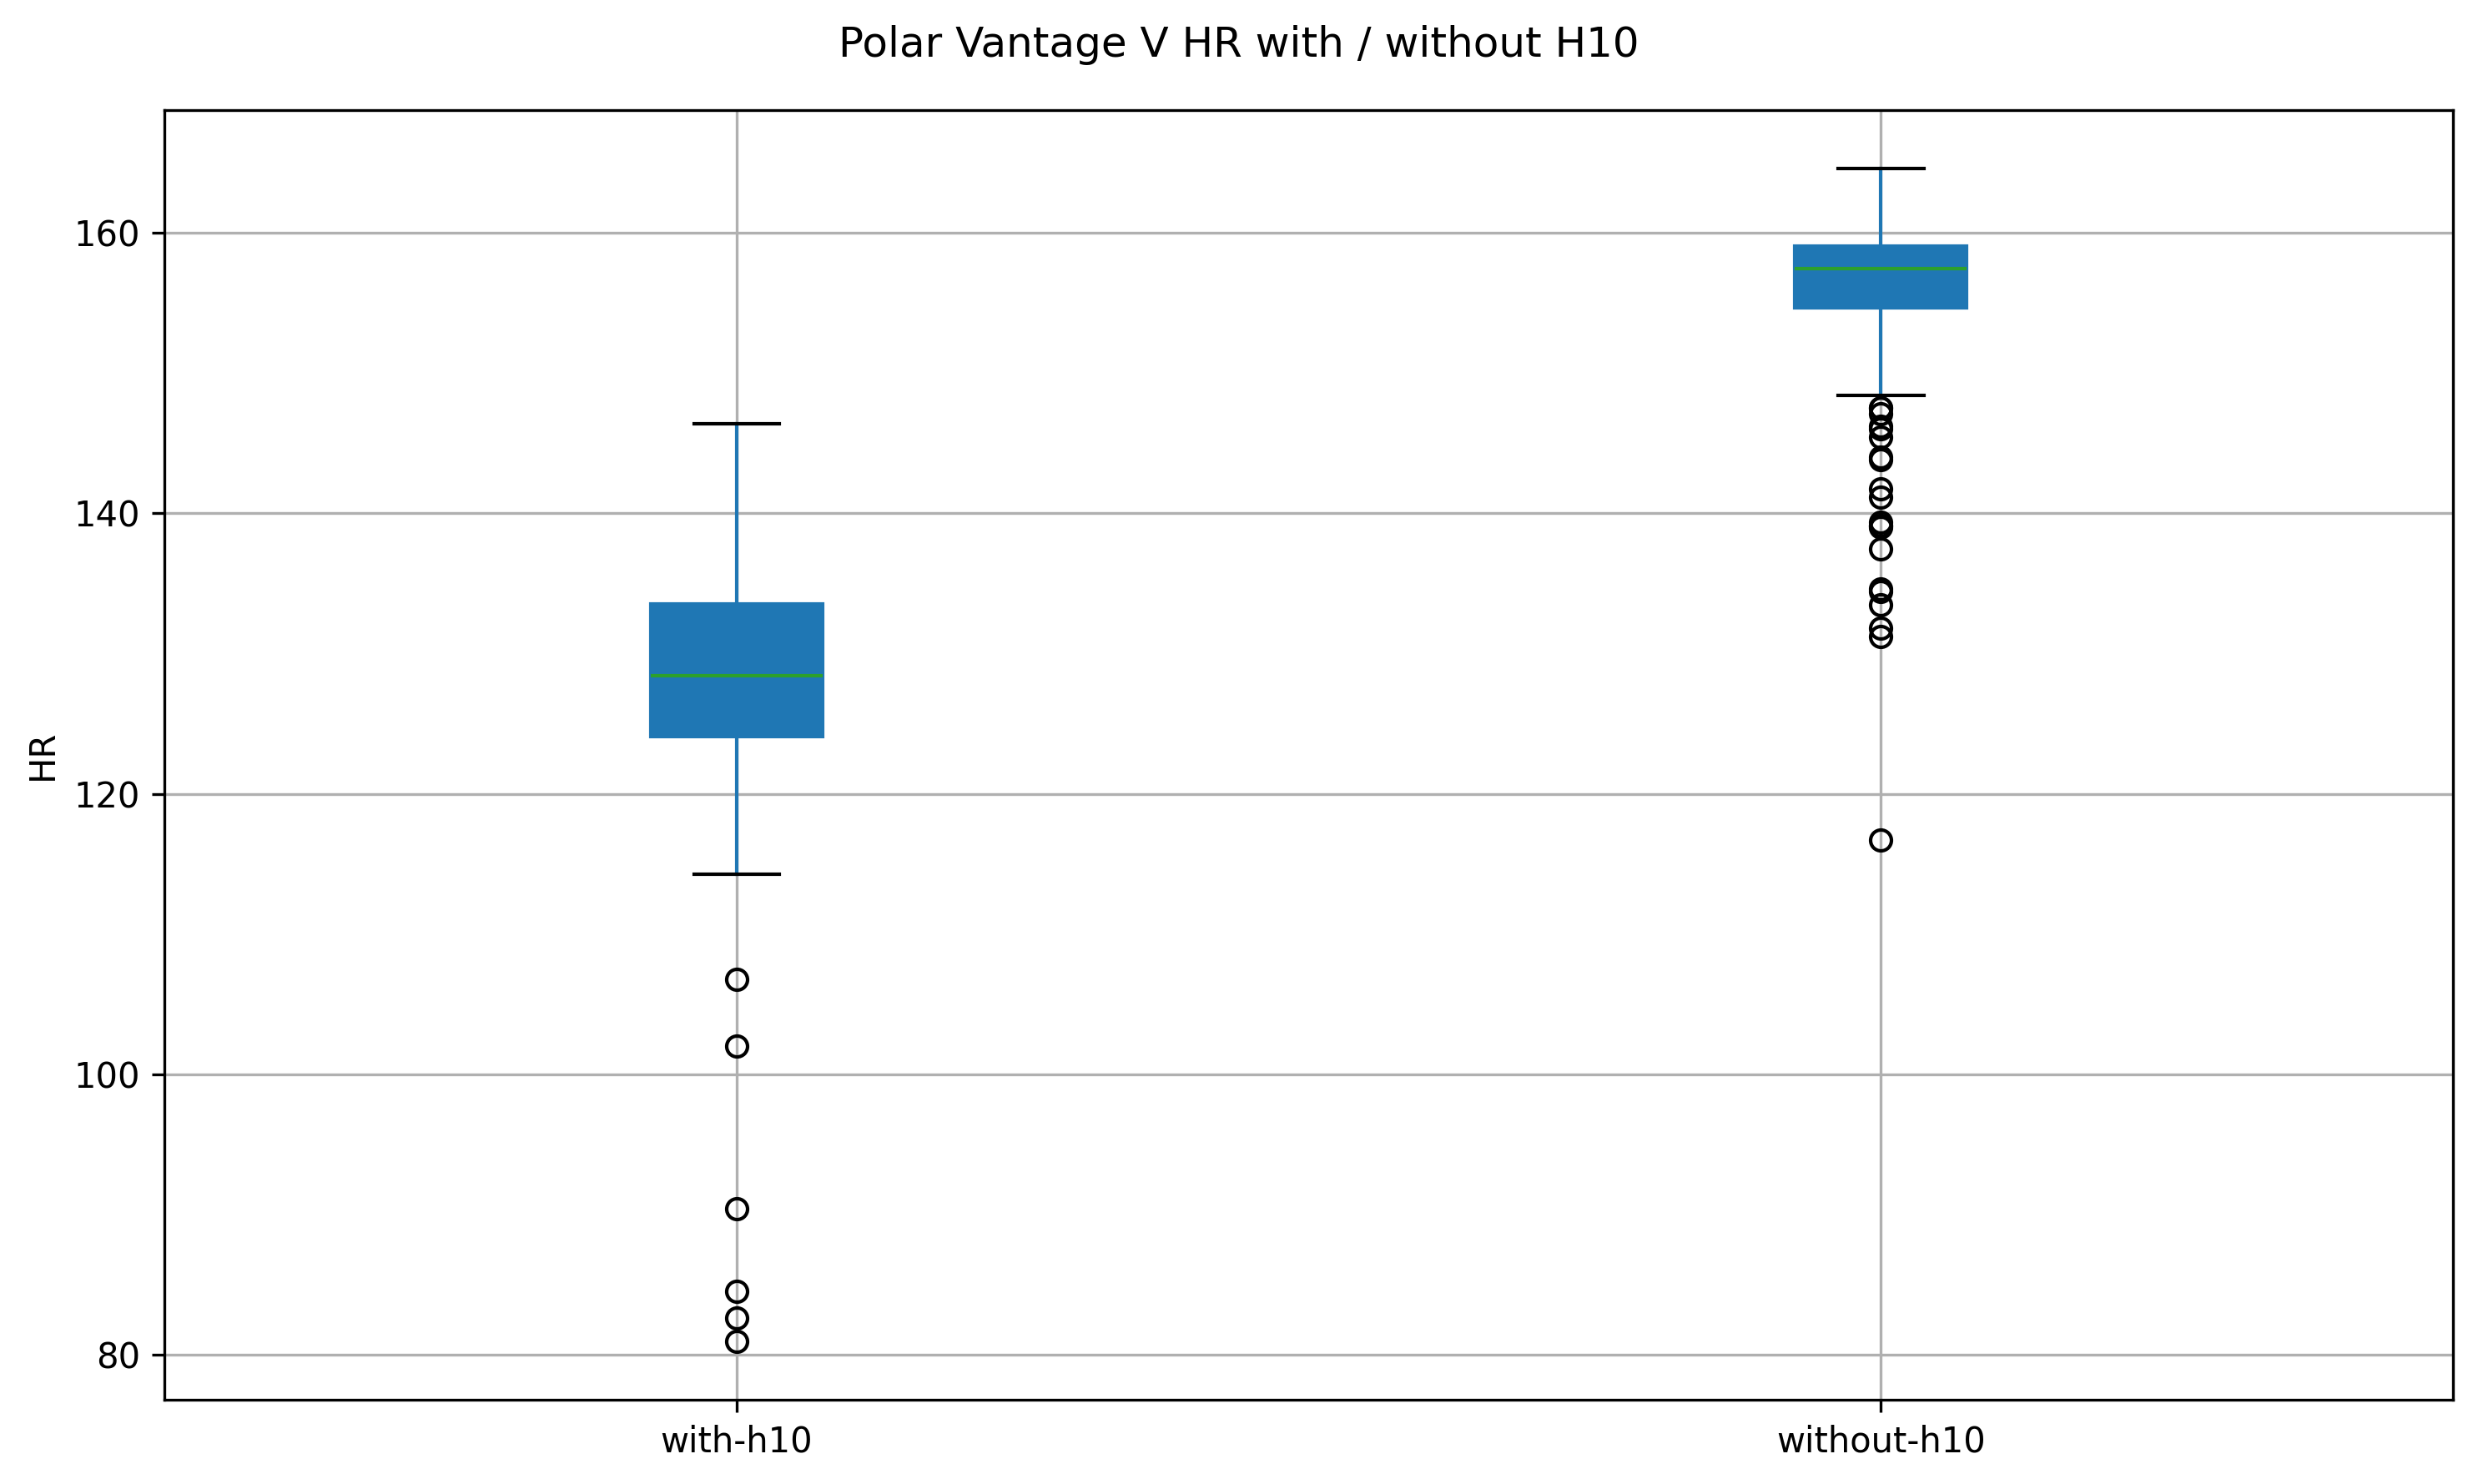

In [4]:
plt.figure(figsize=(10, 6), dpi=300)

plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

ax = plt.gca()
df.boxplot(column='hr', by='category', ax=ax, patch_artist=True)

plt.title('')
plt.suptitle('Polar Vantage V HR with / without H10')  # Set the main title

plt.ylabel('HR')
plt.xlabel('')

plt.tight_layout()
plt.show()

In [53]:
grouped = df.groupby('category')['hr']
stats = grouped.describe()
stats

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
with-h10,122.0,127.554164,10.651921,81.0,124.065541,128.400000,133.5125,146.390244
without-h10,122.0,155.210476,7.322482,131.2,153.620833,157.577976,159.8375,164.550000
